## Machine Learning
At this point, we have filtered candidate ouputs of user inputs and ranked the results in order of recommendation. Additionally, we are interested in the future behavior of COVID. It’s undeniable that the pandemic influences the population socially and studying its movement can help with citizen's judgement. Getting quantitative, we will use Bollinger Bands to obtain some volatility analysis on the trend and fluctuation of COVID data.

**Data that we used**: For this methods of forecasting, the Bollinger Bands Analysis and the following quantitative forecast, we will use `coviddata`, which contains historical daily COVID cases for New York City. First, we divide the full data into training, validation and testing datasets. We will use observations before [] for model development, observations before [] for model validation, and the most recent data points for predicting future behaviors.

**Source**: https://github.com/nychealth/coronavirus-data


In [ ]:
# Packages preparation
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

## Boolinger Bands
According to the Bollinger Bounce Property, we expect the COVID counts to bounce from one side of the band to the other. It has a tendency to return to the moving average. When the number of cases breaks out of the upper bound, we expect it to continue the upward trend. When the number of cases breaks out of the lower bound, we expect it to continue to decrease.

**Parameters of Bollinger Bands(BB)**
- Window of Moving Average(MA):
    - Conventionally, people utilize two types of Bollinger Bands: short and long.
    - Short BB has moving average generated from 5-day lookback windows; whereas long BB has moving average of 20 or 30 days.
- Standard Deviation of BB: It is common to use 2 standard deviation as width of the bands
- Method of MA: Simple Moving Average(SMA) of given window period

In [ ]:
# Bollinger Bands Helper Functions
def BollingerBands(data, days, noStd=2, plot=False):
    """
    Parameters: {
        data: the data containing column ["CASE_COUNT"]
        days: window of moving average
        noStd: number of standard deviation, the width of bands
    }
    Return: updated dataframe with 
            [MA, MA STD, MA Upper Bound, MA Lower Bound, BreakoutSignal]
    """
    # Simple Moving Average
    data['MA'] = data["CASE_COUNT"].rolling(window=days).mean()
    data['MA_STD'] = data["CASE_COUNT"].rolling(window=days).std()
    data['MA_Upper'] = data['MA'] + data['MA_STD'] * noStd
    data['MA_Lower'] = data['MA'] - data['MA_STD'] * noStd
    
    breakout_upper = np.where(data["CASE_COUNT"] > data['MA_Upper'], 1, 0)     # +1 when hit upper band
    breakout_lower = np.where(data["CASE_COUNT"] < data['MA_Lower'], -1, 0)    # -1 when hit lower band
    
    data['BreakoutSignal'] = breakout_upper + breakout_lower
    data['BreakoutSignal'].fillna(method='ffill',inplace=True)    # Forward fill to replace the "None" values
    
    # plot bands
    if plot:
        plt.plot( data["CASE_COUNT"], label="Training Data" )
        plt.plot( data[['MA']], alpha=0.7, label="Moving Average")
        plt.plot( data[['MA_Lower']], alpha=0.7, label="Lower Bound")
        plt.plot( data[['MA_Upper']], alpha=0.7, label="Upper Bound")
        plt.scatter(data[data["BreakoutSignal"] == -1].index, data[data["BreakoutSignal"] == -1]["CASE_COUNT"], c='g', label="Lower Signal")
        plt.scatter(data[data["BreakoutSignal"] == 1].index, data[data["BreakoutSignal"] == 1]["CASE_COUNT"], c='r', label="Upper Signal")
        plt.title( "{} days SMA Bollinger Bands of {}".format(str(days), "CASE_COUNT") )
        plt.ylabel("CASE_COUNT")
        plt.legend()

In [ ]:
# Prepare ML data
coviddata = pd.read_csv("COVID-19_Daily_Counts_of_Cases.csv")
coviddata['date_of_interest'] = coviddata['date_of_interest'].apply(pd.to_datetime, utc=True)
coviddata = coviddata.set_index(['date_of_interest'])

covidtrain = coviddata.truncate('2020-03-01', '2020-12-31') # Prepare training data: upto 12/31/20
covidvalid = coviddata.truncate('2021-01-01', '2021-3-31') # We will use data upto 01/01/21 as validation data
covidtest = coviddata.truncate('2021-4-01')  # We will use data after 3/31/21 as testing data
covidvalid.head()

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


,CASE_COUNT
date_of_interest,
2021-01-01 00:00:00+00:00,1323
2021-01-02 00:00:00+00:00,4191
2021-01-03 00:00:00+00:00,3446
2021-01-04 00:00:00+00:00,6571
2021-01-05 00:00:00+00:00,6141


### Optimize Paramerters on Training Set

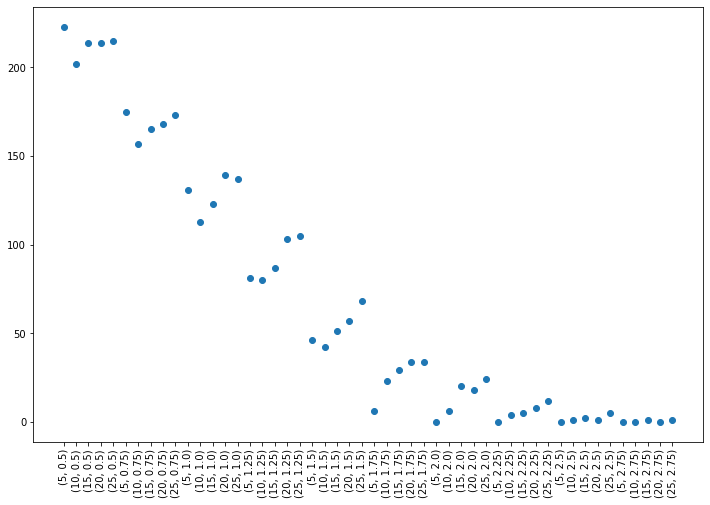

In [ ]:
# Optimize window(from 5 to 30) & std(from 0.5 to 3)
pair = []
sig = []
for std in np.arange(0.5,3.0,0.25):
    for win in np.arange(5,30,5):
        pair.append((win,std))
        BollingerBands(covidtrain, win, std)
        sig.append(sum(covidtrain['BreakoutSignal'] != 0))

# check the number of signals produced by each combination
plt.figure(figsize=(12, 8))
plt.scatter([str(i) for i in pair], sig)
plt.xticks(rotation=90)
plt.show()

### Validate Parameters on Validation Set
**Parameters of Bollinger Bands(BB)**
- Window of Moving Average(MA):
    - For NY COVID data, we choose an optimal value of 20-day lookback window that is most sentisitve to the training data, while keeping number of signals relatively low.
- Standard Deviation of BB: We use slightly tighter 1.75 standard deviation as width of the bands
- Method of MA: Simple Moving Average(SMA) of given window period

The *blue curve*, *black curve* and *purple curve* are the training, validation, and testing daily cases of NYC. The *yellow curve* is the 15-day moving average of daily cases and deaths. The *red curve* and *green curve* are the upper and lower Bollinger Band, which are 2 standard deviations from the moving average. The *red dots* and *green dots* indicate observed counts exceeding the upper and lower limit.

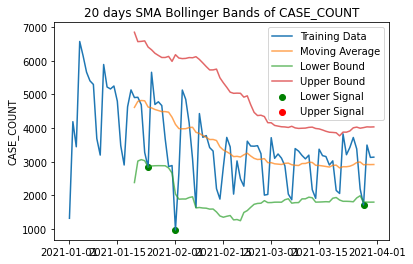

In [ ]:
# Validation
BollingerBands(covidvalid, 20, 1.75, plot=True)

We successfully capture *green* drop signals before descending trends.

### Testing Up-to-date Dataset

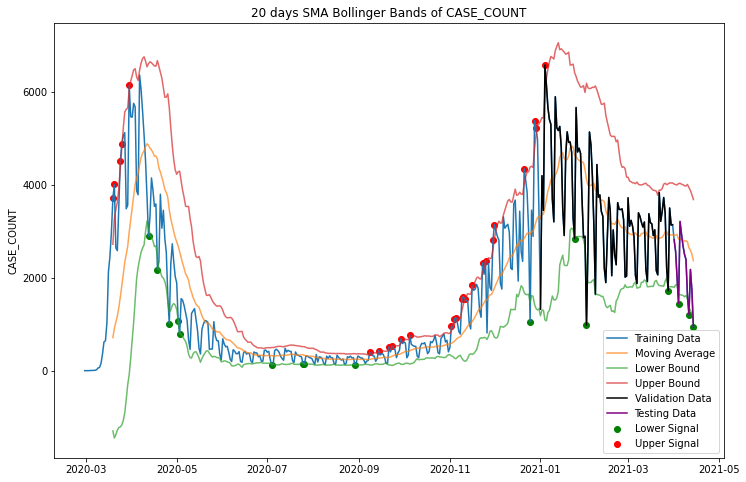

In [ ]:
# Plot ML results
plt.figure(figsize=(12, 8))
BollingerBands(coviddata, 20, 1.75, True)
plt.plot(covidvalid['CASE_COUNT'], label="Validation Data", color='Black')
plt.plot(covidtest['CASE_COUNT'], label="Testing Data", color='purple')
plt.legend()
plt.show()
#plt.savefig('covid_trend.png',)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09a12e0c-06d7-4999-ad39-39e13a535978' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>